In [320]:
import pandas as pd
import numpy as np
import warnings
idx = pd.IndexSlice
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

In [321]:
import glob
files = glob.glob("*.csv")

In [264]:
data = [pd.read_csv(file, encoding = 'ISO-8859-1', header=1) for file in files]

In [265]:
all_ = []
for df in data: 
    grouped = df.groupby(['Series'])
    for feature in df.Series.unique():
        frame = grouped.get_group(feature)
        wide = frame[frame.Year == 2015].loc[:, idx['Series', 'Value', 'Unnamed: 1']]
        wide.Value.replace(to_replace = ',', value= '_', regex = True, inplace = True) 
        wide.Value = wide.Value.astype(dtype = 'float64')
        pivot = pd.pivot_table(wide, columns='Series', index='Unnamed: 1').Value.reset_index()
        all_.append(pivot)

In [266]:
fragile_index = pd.read_excel(r'/Users/bridget/Desktop/FragileIndex-2015.xlsx')
fragile_target = fragile_index.loc[:, ['Country','Total']]

In [267]:
fragile_target.set_index('Country', inplace=True)
fragile_target.rename({'United States':'United States of America', 'South Korea': "Dem. People's Rep. Korea",
                      'Czech Republic': 'Czechia', 'Slovak Republic': 'Slovakia', 'North Korea': 'Republic of Korea', 
                      'Guinea Bissau': 'Guinea-Bissau', "Cote d'Ivoire": 'Cote Ivoire', 
                       'Congo Democratic Republic': 'Dem. Rep. of the Congo', 'Congo Republic': 'Congo', 
                       'Syria': 'Syrian Arab Republic', 'Israel and West Bank':'Israel'},inplace=True)

In [268]:
fragile_target=fragile_target.unstack().reset_index().drop('level_0', axis=1)
fragile_target.rename(columns={0:'Fragility'}, inplace=True )

In [269]:
fragile_target.head()

,Country,Fragility
0,South Sudan,114.5
1,Somalia,114.0
2,Central African Republic,111.9
3,Sudan,110.8
4,Dem. Rep. of the Congo,109.7


In [270]:
fragile_target['Country'][14]

'Cote Ivoire'

In [271]:
len(fragile_target)

178

In [272]:
for df_ in all_:
    df_.rename(columns={'Unnamed: 1': 'Country'}, inplace = True)
    df_["Country"] = df_["Country"].replace('Côte d\x92Ivoire','Cote Ivoire',regex=True)
for df_ in all_:
    fragile_target = fragile_target.merge(df_, how='left', on='Country')

In [273]:
fragile_target.isna().sum()

Country                                                                                                           0
Fragility                                                                                                         0
Consumer price index: General                                                                                    24
Consumer price index: Food                                                                                       39
GDP in current prices (millions of US dollars)                                                                   12
GDP per capita (US dollars)                                                                                      12
GDP in constant 2010 prices (millions of US dollars)                                                             12
GDP real rates of growth (percent)                                                                               12
Intentional homicide rates per 100,000                                  

In [274]:
# un_predictors = fragile_target[['Country', 'Total', 'Consumer price index: Food', 
#                                    'Consumer price index: General', 'GDP per capita (US dollars)',
#                                    'GDP real rates of growth (percent)',
#                                    'Assault rate per 100,000 population',
#                                    'Asylum seekers, including pending cases (number)',
#                                    'Percentage of individuals using the internet',
#                                     'Unemployment rate - Total',
#                                     'Life expectancy at birth for both sexes (years)',
#                                     'Population annual rate of increase (percent)',
#                                     'Public expenditure on education (% of GDP)',
#                                     'Seats held by women in national parliament, as of February (%)']]

In [275]:
# some features like assault rate, public expenditure on education interested in have mostly nan values so must reselect "
# un_predictors

In [276]:
un_predictors = fragile_target[['Country', 'Fragility', 'Consumer price index: Food', 
                                   'Consumer price index: General', 'GDP per capita (US dollars)',
                                   'GDP real rates of growth (percent)',
                                   'Intentional homicide rates per 100,000',
                                   'Asylum seekers, including pending cases (number)',
                                   'Percentage of individuals using the internet',
                                    'Unemployment rate - Total',
                                    'Life expectancy at birth for both sexes (years)',
                                    'Population annual rate of increase (percent)',
                                    'Public expenditure on education (% of government expenditure)',
                                    'Seats held by women in national parliament, as of February (%)']]

In [277]:
#un_predictors.isna().sum()
# Country                                                             0
# Total                                                               0
# Consumer price index: Food                                         47
# Consumer price index: General                                      34
# GDP per capita (US dollars)                                        23
# GDP real rates of growth (percent)                                 23
# Intentional homicide rates per 100,000                             89
# Asylum seekers, including pending cases (number)                   44
# Percentage of individuals using the internet                       24
# Unemployment rate - Total                                          27
# Life expectancy at birth for both sexes (years)                    22
# Population annual rate of increase (percent)                       22
# Public expenditure on education (% of government expenditure)     133
# Seats held by women in national parliament, as of February (%)     27
# dtype: int64

In [278]:
un_predictors.isna().sum()

Country                                                             0
Fragility                                                           0
Consumer price index: Food                                         39
Consumer price index: General                                      24
GDP per capita (US dollars)                                        12
GDP real rates of growth (percent)                                 12
Intentional homicide rates per 100,000                             81
Asylum seekers, including pending cases (number)                   34
Percentage of individuals using the internet                       13
Unemployment rate - Total                                          16
Life expectancy at birth for both sexes (years)                    12
Population annual rate of increase (percent)                       12
Public expenditure on education (% of government expenditure)     128
Seats held by women in national parliament, as of February (%)     17
dtype: int64

In [279]:
#all_[1]['Country'][41]
un_predictors.drop(columns=['Public expenditure on education (% of government expenditure)','Intentional homicide rates per 100,000', 'Consumer price index: Food'], axis=1, inplace = True)

In [280]:
un_predictors.isna().sum()

Country                                                            0
Fragility                                                          0
Consumer price index: General                                     24
GDP per capita (US dollars)                                       12
GDP real rates of growth (percent)                                12
Asylum seekers, including pending cases (number)                  34
Percentage of individuals using the internet                      13
Unemployment rate - Total                                         16
Life expectancy at birth for both sexes (years)                   12
Population annual rate of increase (percent)                      12
Seats held by women in national parliament, as of February (%)    17
dtype: int64

In [281]:
model_data=un_predictors.drop('Country', 1)

In [282]:
target = model_data['Fragility']
predictors = model_data.drop('Fragility', 1)

# EDA

In [283]:
predictors.describe()

,Consumer price index: General,GDP per capita (US dollars),GDP real rates of growth (percent),"Asylum seekers, including pending cases (number)",Percentage of individuals using the internet,Unemployment rate - Total,Life expectancy at birth for both sexes (years),Population annual rate of increase (percent),"Seats held by women in national parliament, as of February (%)"
count,154.000000,166.000000,166.000000,144.000000,165.000000,162.000000,166.000000,166.000000,161.000000
mean,130.018182,13045.090361,2.743373,16204.604167,46.176364,7.682716,70.760843,1.489759,21.029736
std,46.981709,18065.519989,6.300672,74415.215632,28.940410,5.565350,8.412241,1.414326,11.647120
min,98.200000,105.000000,-45.500000,1.000000,0.000000,0.200000,49.400000,-2.300000,0.000000
25%,108.700000,1415.750000,1.700000,110.750000,19.700000,4.300000,64.500000,0.500000,12.500000
50%,116.400000,4945.000000,3.250000,677.000000,47.600000,6.150000,72.900000,1.400000,19.700000
75%,132.975000,15659.250000,4.900000,7836.250000,71.400000,9.900000,76.700000,2.300000,28.300000
max,448.800000,100936.000000,25.800000,798080.000000,98.200000,27.700000,83.300000,6.600000,63.800000


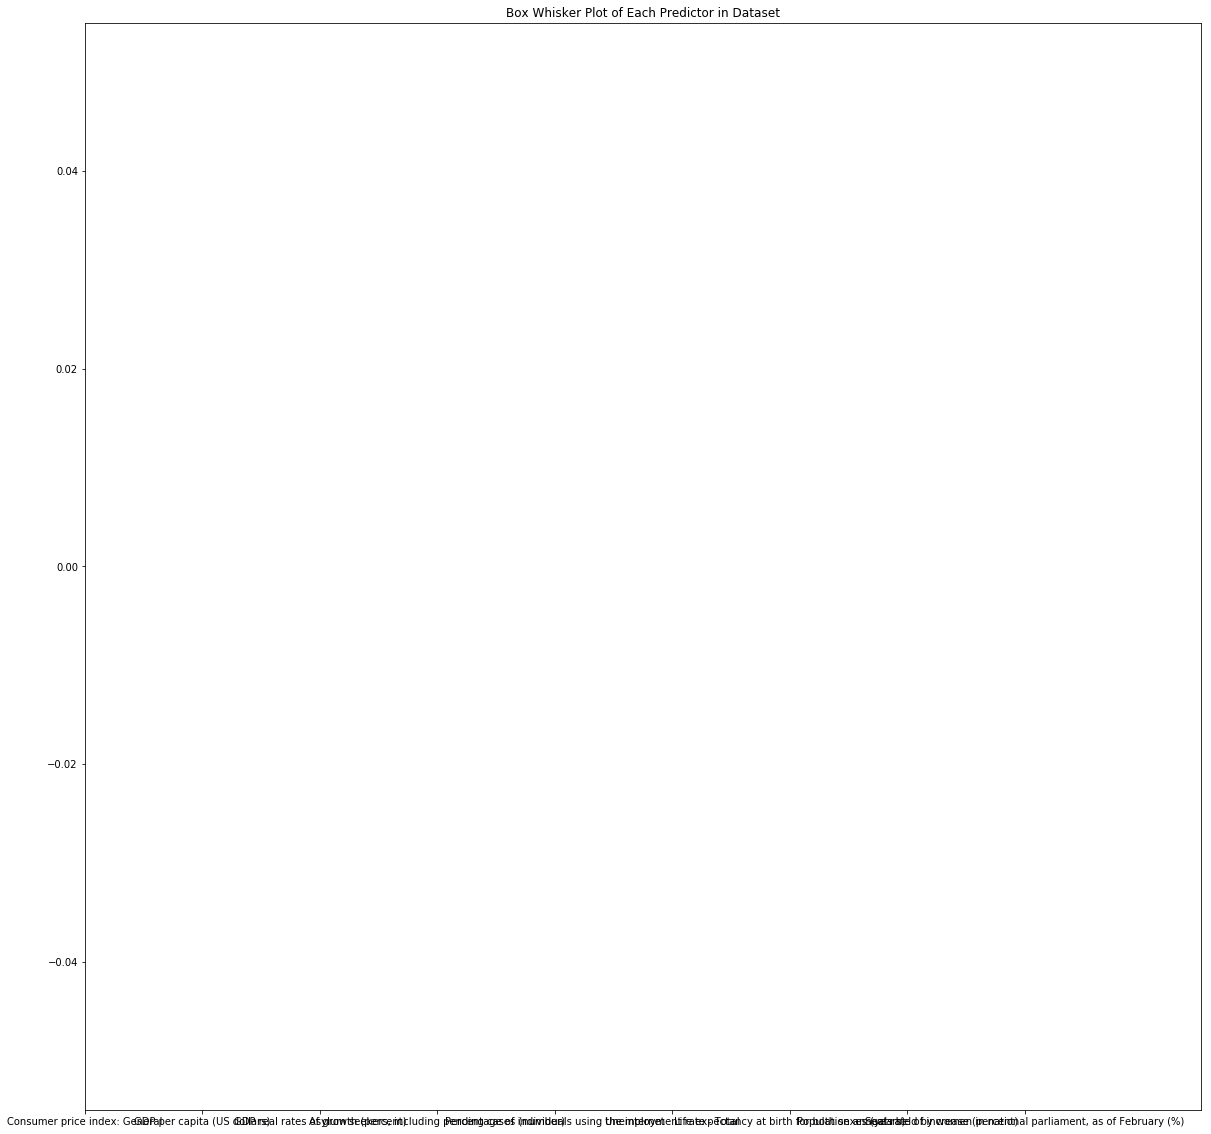

In [284]:
plt.figure(figsize=(20, 20))
plt.boxplot([predictors[col] for col in predictors.columns])
plt.title("Box Whisker Plot of Each Predictor in Dataset")
plt.xticks(range(len(predictors.columns.values)), predictors.columns.values)
plt.show()

In [285]:
# from pandas.tools.plotting import scatter_matrix
# from matplotlib import cm
# feature_names = ['mass', 'width', 'height', 'color_score']
# X = fruits[feature_names]
# y = fruits['fruit_label']
# cmap = cm.get_cmap('gnuplot')
# scatter = pd.scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(9,9), cmap = cmap)
# plt.suptitle('Scatter-matrix for each input variable')
# plt.savefig('fruits_scatter_matrix')

In [286]:
target = pd.cut(target, bins=[0, 29, 59, 89, 120],
                     labels =[0, 1, 2, 3])

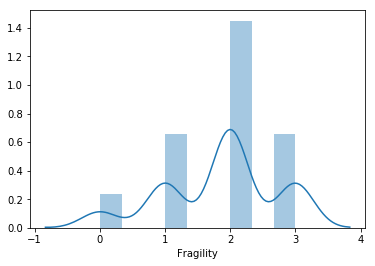

In [287]:
sns.distplot(target)

In [288]:
predictors = predictors.apply(lambda x: x.fillna(x.median()),axis=0)

In [289]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dummy Classifier 

In [290]:
#Baseline Performance 
from sklearn.dummy import DummyClassifier
dum_clf = DummyClassifier(strategy= 'most_frequent').fit(X_train, y_train)
y_pred = dum_clf.predict(X_test)

print('Actual Fragility :  \n'+ str(y_test.value_counts()))
print('Baseline Predicted Fragility : \n' + str(pd.Series(y_pred).value_counts()))

Actual Fragility :  
2    25
3    10
1     7
0     3
Name: Fragility, dtype: int64
Baseline Predicted Fragility : 
2    45
dtype: int64


# **Logistic Regression**

In [291]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))

Accuracy of Logistic regression classifier on test set: 0.67
Accuracy of Logistic regression classifier on training set: 0.62


In [293]:
from sklearn.model_selection import cross_val_score

logreg_cv_score = cross_val_score(logreg, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(logreg_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score * 100))

Mean Cross Validation Score: 53.39%


In [260]:
# Evaluation

In [304]:
log_pred = logreg.predict(X_test)
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,log_pred)))

Confusion Matrix : 
[[ 0  3  0  0]
 [ 0  1  6  0]
 [ 0  0 24  1]
 [ 0  0  5  5]]


In [305]:
from sklearn.metrics import classification_report
print(classification_report(y_test,log_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      0.14      0.18         7
           2       0.69      0.96      0.80        25
           3       0.83      0.50      0.62        10

    accuracy                           0.67        45
   macro avg       0.44      0.40      0.40        45
weighted avg       0.61      0.67      0.61        45



In [306]:
from sklearn.model_selection import GridSearchCV

# Decision Tree

In [210]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on test set: 0.51
Accuracy of Decision Tree classifier on training set: 1.00


In [212]:
dclf_cv_score = cross_val_score(clf, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(dclf_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score * 100))

Mean Cross Validation Score: 66.81%


In [308]:
clf_pred = clf.predict(X_test)

In [309]:
print(classification_report(y_test, clf_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         7
           2       0.56      1.00      0.71        25
           3       0.00      0.00      0.00        10

    accuracy                           0.56        45
   macro avg       0.14      0.25      0.18        45
weighted avg       0.31      0.56      0.40        45



# K-Nearest Neighbors 

In [165]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of K-NN classifier on test set: 0.78
Accuracy of K-NN classifier on training set: 0.77


In [213]:
knn_cv_score = cross_val_score(knn, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(knn_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score * 100))

Mean Cross Validation Score: 69.84%


In [313]:
knn_pred = knn.predict(X_test)
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.67      0.86      0.75         7
           2       0.83      0.80      0.82        25
           3       0.75      0.60      0.67        10

    accuracy                           0.78        45
   macro avg       0.75      0.81      0.77        45
weighted avg       0.78      0.78      0.78        45



In [ ]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# Linear Discriminant Analysis  

In [166]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))

Accuracy of LDA classifier on test set: 0.71
Accuracy of LDA classifier on training set: 0.74


In [214]:
lda_cv_score = cross_val_score(lda, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(lda_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score * 100))

Mean Cross Validation Score: 66.11%


In [314]:
lda_pred = lda.predict(X_test)
print(classification_report(y_test, lda_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.71      0.71      0.71         7
           2       0.76      0.76      0.76        25
           3       0.55      0.60      0.57        10

    accuracy                           0.71        45
   macro avg       0.75      0.69      0.71        45
weighted avg       0.72      0.71      0.71        45



# Random Forest 

In [167]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)
print('Accuracy of Random Forest classifier on test set: {:.2f}'
     .format(forest.score(X_test, y_test)))
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(forest.score(X_train, y_train)))

Accuracy of Random Forest classifier on test set: 0.67
Accuracy of Random Forest classifier on training set: 0.98


In [171]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [172]:
forest.feature_importances_

array([0.06255767, 0.25709179, 0.04091498, 0.04462222, 0.21479409,
       0.04560167, 0.16930005, 0.08980831, 0.07530921])

In [215]:
forest_cv_score = cross_val_score(forest, X_train, y_train, cv=3)
mean_dt_cv_score = np.mean(forest_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_dt_cv_score * 100))

Mean Cross Validation Score: 71.52%


In [315]:
forest_pred = forest.predict(X_test)
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.50      0.57      0.53         7
           2       0.74      0.80      0.77        25
           3       0.62      0.50      0.56        10

    accuracy                           0.67        45
   macro avg       0.59      0.55      0.56        45
weighted avg       0.66      0.67      0.66        45

